# Project
Fetch the data here: https://www.kaggle.com/datasets/arnaud58/landscape-pictures?resource=download

Unzip the data and add it to the project folder under `/data`

In [407]:
#%%capture
#!unzip archive.zip -d data

## Dependencies

In [2]:
import torch

from torchvision.transforms import Compose, ToTensor, RandomResizedCrop, RandomHorizontalFlip, RandomRotation, Grayscale, Normalize
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import PIL.Image as Image
import os
import torch.optim as optim
import matplotlib.pyplot as plt

import random
from math import ceil


## Dataset 

In [3]:
class LandscapeDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = [file for file in os.listdir(main_dir) if file.endswith((".jpg", 'JPG', 'jpeg',"png"))]

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [224]:
image_transforms = Compose([
    ToTensor(), 
    #RandomRotation(180),
    Normalize(0.5, 0.5),
    Grayscale(num_output_channels=1),
    RandomResizedCrop((128,128), (1, 1)), 
    RandomHorizontalFlip()])
data = LandscapeDataset("all_data", image_transforms)

image_transforms_colours = Compose([
    ToTensor(), 
    #RandomRotation(180),
    Normalize(0.5, 0.5),
    RandomResizedCrop((128,128), (1, 1)), 
    RandomHorizontalFlip()])

image_transforms_colours_f= Compose([
    ToTensor(),
    Normalize(0.5, 0.5),
    RandomResizedCrop((128,128), (1, 1))])

image_transforms_f= Compose([
    ToTensor(),
    Normalize(0.5, 0.5),
    Grayscale(num_output_channels=1),
     RandomResizedCrop((128,128), (1, 1))])
dataColours = LandscapeDataset("all_data", image_transforms)

## Displaying Images
Some image showing helper functions

In [79]:
from requests import patch


def show(image):
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    
def get_show_image(dataset, n=None):
    image = dataset[n if n is not None else random.randint(0, len(dataset))]
    show(image)
    
def show_images(images):
    n, m = (1,4) if len(images) <= 4 else (1, ceil(len(images)/4))
    fig, axs = plt.subplots(n, m, figsize=(14, 14), squeeze=False)
    for i in range(n):
        for j in range(m):
            image = images[i*4 + j]
            axs[i, j].imshow(image.permute(1, 2, 0), cmap='gray')
            axs[i, j].axis("off")
    fig.show()
    
def show_image_matrix(dataset, n=3, img_idx=None, fixed=False):
    img_idx = random.randint(0, len(dataset)) if fixed else None
    # make a n x n grid of images
    fig, axs = plt.subplots(n, n, figsize=(14, 14))
    for i in range(n):
        for j in range(n):
            image = dataset[img_idx if img_idx is not None else random.randint(0, len(dataset))]
            axs[i, j].imshow(image.permute(1, 2, 0), cmap='gray')
            axs[i, j].axis("off")
    fig.show()
    
# fetch a random 64x64 patch from each image in the batch
def get_patchs(images, patch_size=64, rand=False):
    images = images.detach().clone()
    w, h = images.shape[-2:]
    i = int((w/2) - (patch_size/2)) if not rand else random.randint(0, w - patch_size)
    j = int((h/2) - (patch_size/2)) if not rand else random.randint(0, h - patch_size)
    patchs = images[..., i:i+patch_size, j:j+patch_size].detach().clone()
    images[..., i:i+patch_size, j:j+patch_size] = 0
    return (i, j), patchs, images

def fill_patch(patch_pos, images, patches):
    i, j = patch_pos
    patch_size = patches.shape[-1]
    images = images.detach().clone()
    images[..., i:i+patch_size, j:j+patch_size] = patches
    return images

### Transformation Display

/var/folders/zb/vnggz7wj3bq3mfb3vvhvd0100000gn/T/ipykernel_88194/3588353190.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


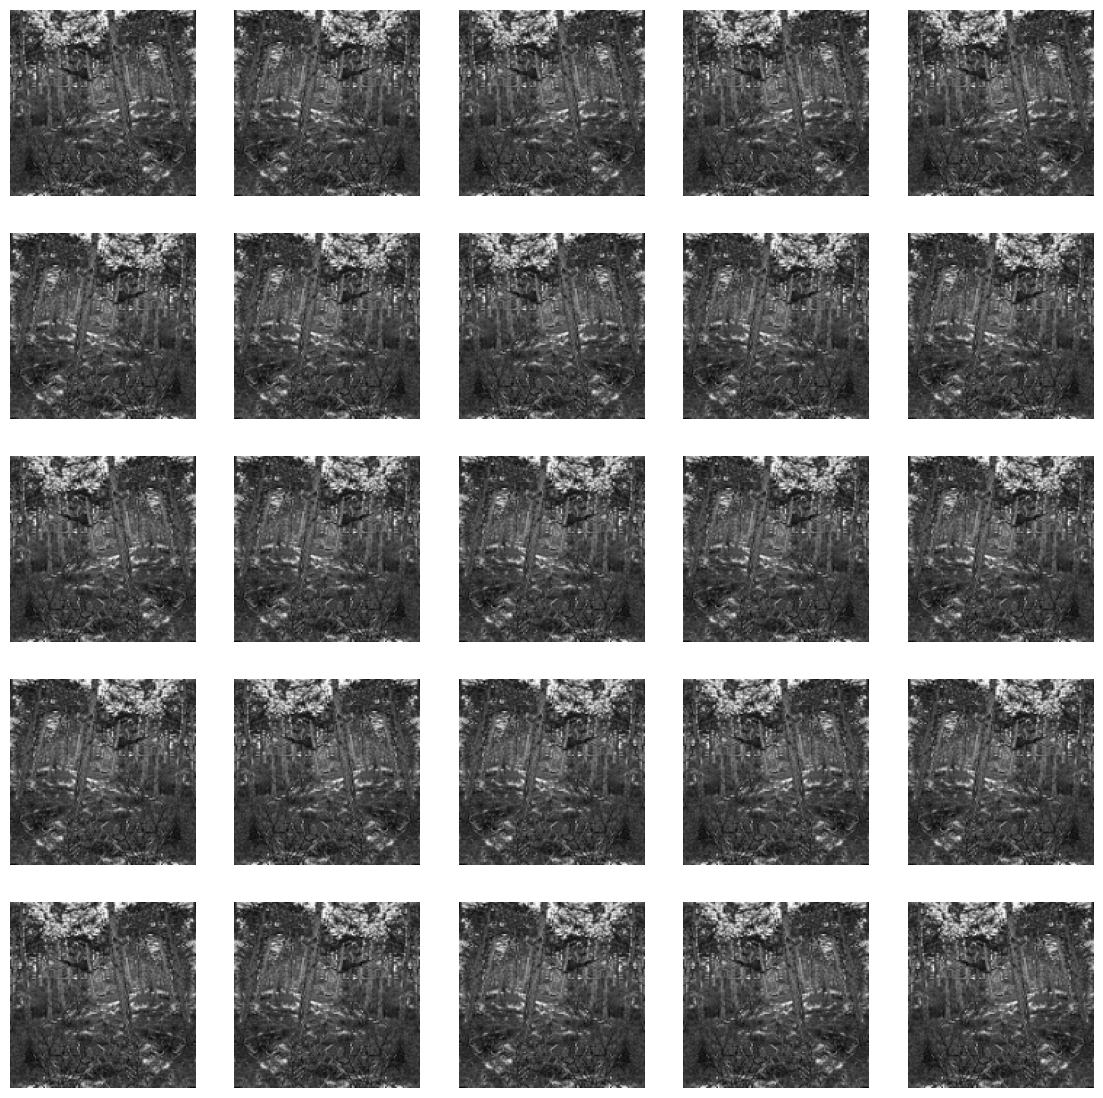

In [7]:
show_image_matrix(data, 5, fixed=True)

### Random imaged and their transformation

/var/folders/zb/vnggz7wj3bq3mfb3vvhvd0100000gn/T/ipykernel_88194/3588353190.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


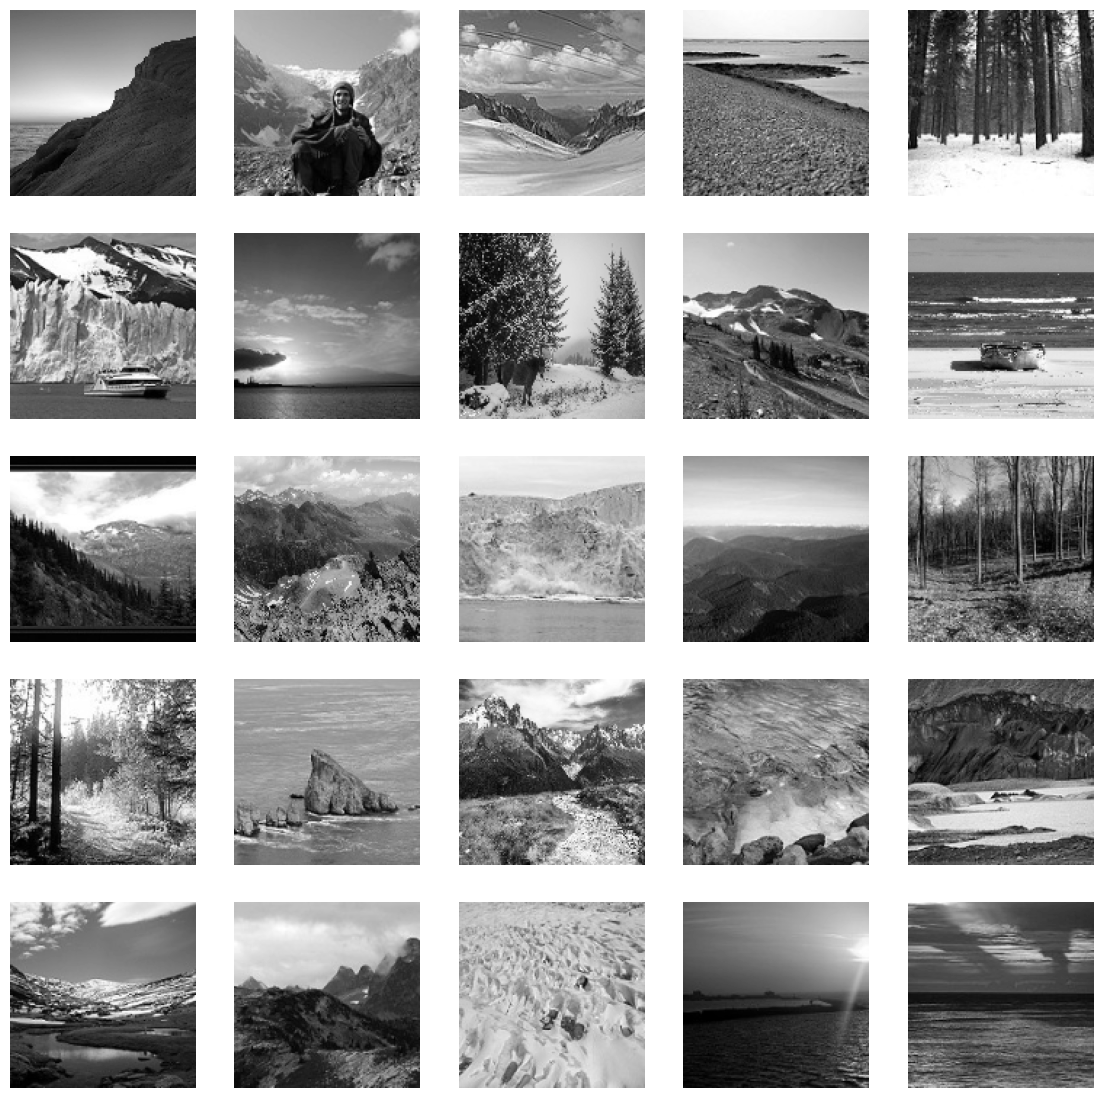

In [8]:
show_image_matrix(data, 5, fixed=False)

## Model

In [9]:
from torch.nn import *

In [10]:
class AutoEncoder(Module):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential(
            Conv2d(1, 64, 4, stride=2, padding=1),
            BatchNorm2d(64),
            LeakyReLU(),
            Conv2d(64, 64, 4, stride=2, padding=1),
            BatchNorm2d(64),
            LeakyReLU(),
            Conv2d(64, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            LeakyReLU(),
            Conv2d(128, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            LeakyReLU(),
            Conv2d(256, 512, 4, stride=2, padding=1),
            BatchNorm2d(512),
            LeakyReLU(),
            Conv2d(512, 4000, 4),
            BatchNorm2d(4000),
            LeakyReLU(),
        )
         
        self.decoder = Sequential(
            ConvTranspose2d(4000, 512, 4),
            BatchNorm2d(512),
            ReLU(),
            ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            ReLU(),
            ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            ReLU(),
            ConvTranspose2d(128, 32, 4, stride=2, padding=1),
            BatchNorm2d(32),
            ReLU(),
            ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            BatchNorm2d(1),
            Tanh()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [134]:
class AutoEncoderColour(Module):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential(
            Conv2d(3, 64, 4, stride=2, padding=1),
            BatchNorm2d(64),
            LeakyReLU(),
            Conv2d(64, 64, 4, stride=2, padding=1),
            BatchNorm2d(64),
            LeakyReLU(),
            Conv2d(64, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            LeakyReLU(),
            Conv2d(128, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            LeakyReLU(),
            Conv2d(256, 512, 4, stride=2, padding=1),
            BatchNorm2d(512),
            LeakyReLU(),
            Conv2d(512, 4000, 4),
            BatchNorm2d(4000),
            LeakyReLU(),
        )
         
        self.decoder = Sequential(
            ConvTranspose2d(4000, 512, 4),
            BatchNorm2d(512),
            ReLU(),
            ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            ReLU(),
            ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            ReLU(),
            ConvTranspose2d(128, 32, 4, stride=2, padding=1),
            BatchNorm2d(32),
            ReLU(),
            ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            BatchNorm2d(3),
            Tanh()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
model = AutoEncoder()
criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
from torchsummary import summary

summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,088
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          65,600
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         131,200
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         524,544
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        LeakyReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-14            [-1, 51

## Train model

/var/folders/zb/vnggz7wj3bq3mfb3vvhvd0100000gn/T/ipykernel_88194/3588353190.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


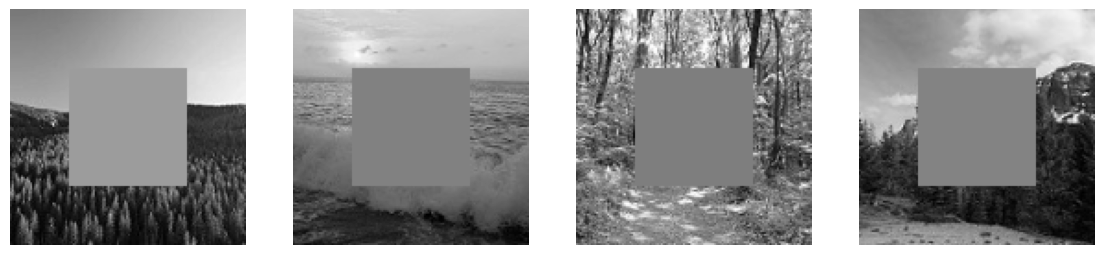

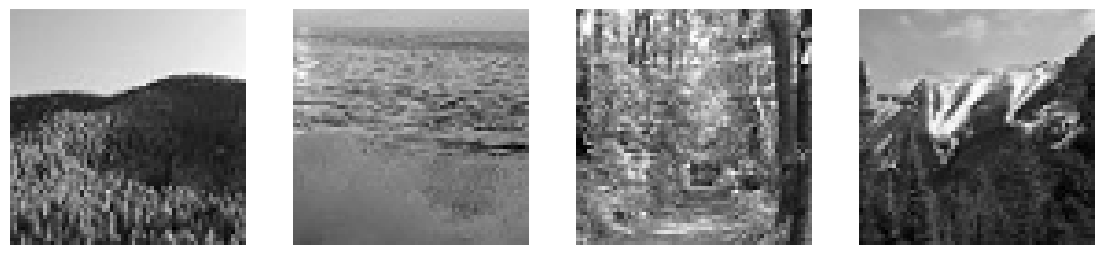

In [13]:
loader = DataLoader(data, batch_size=4, shuffle=True)
img = loader.__iter__().__next__()
patch_pos, patches, images = get_patchs(img)
show_images(images)
show_images(patches)

In [14]:
from torch.utils.tensorboard import SummaryWriter

def train(model, data, criterion, optimizer, batch_size, epochs=10):
    writer = SummaryWriter()
    device = torch.device("mps")
    model.to(device)
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    iters = 1
    for epoch in range(epochs):
        running_loss = 0.0
        for i, batch in enumerate(loader):
            # ===============prep-rocessing==================
            patch_pos, patches, images, _ = get_patchs(batch)
            images_on_gpu = images.to(device)
            patches_on_gpu = patches.to(device)
            # ==================forward======================
            optimizer.zero_grad()
            output = model(images_on_gpu)
            patch_loss = criterion(patches_on_gpu, output)
            # ==================log======================
            writer.add_scalar("Loss/train", patch_loss, iters)
            # ==================backward=====================
            patch_loss.backward()
            optimizer.step()
            running_loss += patch_loss.item()
            iters += 1
        print(f"Epoch {epoch + 1} of {epochs}, Loss: {running_loss/len(loader)}")

    writer.close()


In [ ]:
model = AutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
train(model, data, criterion, optimizer, 16, 3)

## Own internal test set (alex)

/var/folders/zb/vnggz7wj3bq3mfb3vvhvd0100000gn/T/ipykernel_53069/4168760189.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


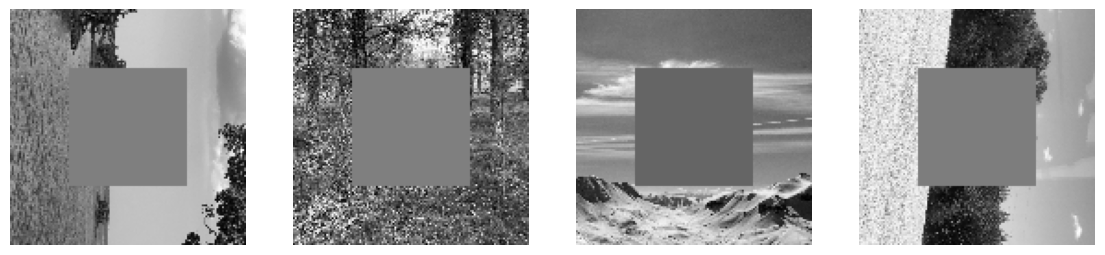

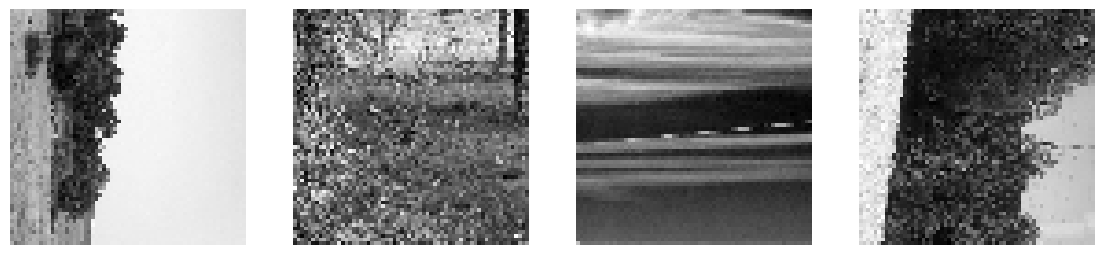

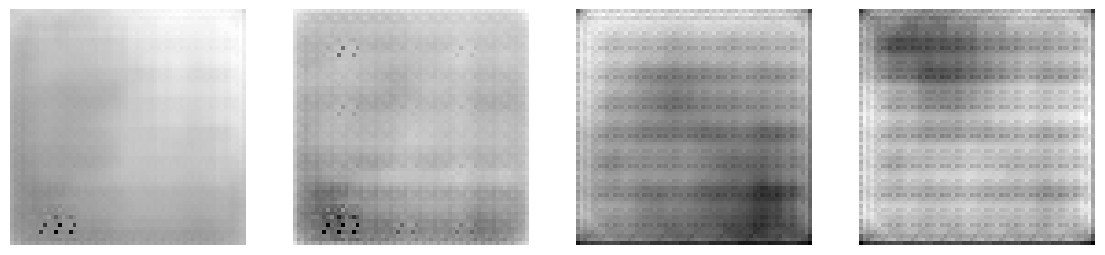

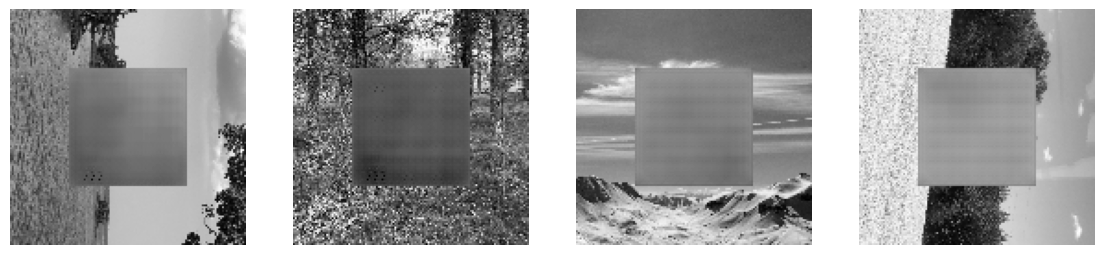

In [422]:
test_data = LandscapeDataset("own_data", image_transforms)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
img = test_loader.__iter__().__next__()
patch_pos, patches, images, _ = get_patchs(img)
show_images(images)
show_images(patches)

model.to("cpu")
predicted_patches = model(images).cpu().detach()

show_images(predicted_patches)
show_images(fill_patch(patch_pos, images, predicted_patches))


# Let's try with adverserial loss

In [15]:
class Discriminator(Module):
    def __init__(self):
        super().__init__()
        self.conv = Sequential(
            Conv2d(1, 64, 4, stride=2, padding=1),
            LeakyReLU(),
            Conv2d(64, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            LeakyReLU(),
            Conv2d(128, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            LeakyReLU(),
            Conv2d(256, 512, 4, stride=2, padding=1),
            Flatten(),
            Linear(8192, 1),
            Sigmoid()
        )
 
    def forward(self, x):
        return self.conv(x)
summary(Discriminator(), (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,088
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
          Flatten-10                 [-1, 8192]               0
           Linear-11                    [-1, 1]           8,193
          Sigmoid-12                    [-1, 1]               0
Total params: 2,763,457
Trainable params: 2,763,457
Non-trainable params: 0
---------------------------

In [136]:
class DiscriminatorColour(Module):
    def __init__(self):
        super().__init__()
        self.conv = Sequential(
            Conv2d(3, 64, 4, stride=2, padding=1),
            LeakyReLU(),
            Conv2d(64, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            LeakyReLU(),
            Conv2d(128, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            LeakyReLU(),
            Conv2d(256, 512, 4, stride=2, padding=1),
            Flatten(),
            Linear(8192, 1),
            Sigmoid()
        )
 
    def forward(self, x):
        return self.conv(x)
summary(DiscriminatorColour(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
          Flatten-10                 [-1, 8192]               0
           Linear-11                    [-1, 1]           8,193
          Sigmoid-12                    [-1, 1]               0
Total params: 2,765,505
Trainable params: 2,765,505
Non-trainable params: 0
---------------------------

## New training function w/Adverserial support

In [137]:
from torch.utils.tensorboard import SummaryWriter


def train_new(
        ae_model, 
        ae_optimizer, 
        disc_model, 
        disc_optimizer, 
        alpha, 
        beta, 
        data, 
        batch_size, 
        epochs=10
):
    writer = SummaryWriter()
    device = torch.device("mps")
    ae_model.to(device)
    disc_model.to(device)
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    
    iters = 1
    for epoch in range(epochs):
        running_loss = 0.0
        for i, batch in enumerate(loader):
            # ===============prep-rocessing==================
            patch_pos, patches, images = get_patchs(batch)
            padded_patch_pos, padded_patches, _ = get_patchs(batch, patch_size=64+14)
            images_on_gpu = images.to(device)
            patches_on_gpu = patches.to(device)
            
            # ==================generator======================
            ae_optimizer.zero_grad()
            
            # generate patches
            ae_output = ae_model(images_on_gpu)

            # discriminator predictions for generated patches
            disc_output_fake = disc_model(ae_output)

            disc_patch_loss_fake = BCELoss()(disc_output_fake, torch.ones_like(disc_output_fake))
            ae_patch_loss = MSELoss()(ae_output, patches_on_gpu)
            
            combined_loss = alpha * ae_patch_loss + beta * disc_patch_loss_fake

            combined_loss.backward()
            ae_optimizer.step()
            
            # ==================discriminator======================
            disc_optimizer.zero_grad()
            
            # discriminator predictions for real patches
            disc_output_real = disc_model(padded_patches)

            disc_patch_loss_real = BCELoss()(disc_output_real, torch.ones_like(disc_output_real))
            disc_patch_loss_fake = BCELoss()(disc_model(ae_output.detach()), torch.zeros_like(disc_output_fake))
            
            disc_patch_loss = (disc_patch_loss_real + disc_patch_loss_fake)/2
            
            disc_patch_loss.backward()
            disc_optimizer.step()

            # ==================log======================
            losses = dict(G=ae_patch_loss, D=disc_patch_loss, C=combined_loss)
            writer.add_scalars("Loss/train", losses, iters)
            disc_predictions = dict(real=torch.mean(disc_output_real), fake=torch.mean(disc_output_fake))
            writer.add_scalars("Predictions/D", disc_predictions, iters)
            iters += 1
        print(f"Epoch {epoch + 1} of {epochs}")

    writer.close()


In [138]:
def train_new_new(
        generator, 
        optimizer_g, 
        discriminator, 
        optimizer_d, 
        alpha, 
        beta, 
        data, 
        batch_size, 
        epochs=10
):
    writer = SummaryWriter()
    device = torch.device("mps")
    generator.to(device)
    discriminator.to(device)
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    
    iters = 1
    for epoch in range(epochs):
        for i, batch in enumerate(loader):
            patch_pos, patches, images = get_patchs(batch)
            padded_patch_pos, padded_patches, _ = get_patchs(batch, patch_size=64+14)

            imgs = images.to(device)
            cutouts = patches.to(device)
            padded_patches = padded_patches.to(device)
            optimizer_g.zero_grad()

            # generate fake images
            fake_imgs = generator(imgs)

            # adversarial and pixelwise loss
            fake_discriminate = discriminator(fake_imgs)
            g_adv = BCELoss()(fake_discriminate, torch.ones_like(fake_discriminate))
            g_pixel = MSELoss()(fake_imgs, cutouts)

            adv_factor = 0.001

            g_loss = adv_factor * g_adv + (1 - adv_factor) * g_pixel

            g_loss.backward()
            optimizer_g.step()

            # TRAIN DISCRIMINATOR

            optimizer_d.zero_grad()

            # real images
            real_discriminate = discriminator(padded_patches)
            real_loss = BCELoss()(real_discriminate, torch.ones_like(real_discriminate))
            fake_loss = BCELoss()(discriminator(fake_imgs.detach()), torch.zeros_like(fake_discriminate))

            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_d.step()

            # ==================log======================
            losses = dict(G=g_pixel, D=d_loss, C=g_loss)
            writer.add_scalars("Loss/train", losses, iters)
            disc_predictions = dict(real=torch.mean(real_discriminate), fake=torch.mean(fake_discriminate))
            writer.add_scalars("Predictions/D", disc_predictions, iters)
            iters += 1

In [18]:
def train_edwin(model, adv_net, model_optim, adv_optim, data, batch_size=64, n_epochs=10, is_large=False):
    #torch.cuda.empty_cache()
    real_label = 1.
    fake_label = 0.
    bce = BCELoss()
    mse = MSELoss()
    device = torch.device("mps")
    model.to(device)
    adv_net.to(device)
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    disc_pred_gen = []
    disc_pred_org = []
    adv_losses = []
    model_adv_losses = []
    model_mse_losses = []
    model_losses = []
    writer = SummaryWriter()
    iters = 0
    for i in range(n_epochs):
        for batch in data_loader:
            adv_net.zero_grad()
            
            # Data setup
            cbs = batch.size(0) # Current batch size 
            full_images = batch
            patch_pos, patches, images, padded_patches = get_patchs(full_images)
            images, full_images, patches, padded_patches = images.to(device), full_images.to(device), patches.to(device), padded_patches.to(device)
            ### adv_net
            ## Step 1
            label = torch.full((cbs,), real_label, dtype=torch.float, device=device)
            output = adv_net(patches.detach()).view(-1)
            disc_real_loss = bce(output, label)
            disc_real_loss.backward()
            disc_pred_real = output.mean().item()
            disc_pred_org.append(disc_pred_real)
            
            ## Step 2
            fake = model(images)
            label.fill_(fake_label)
            
            output = adv_net(fake.detach()).view(-1)
            disc_fake_loss = bce(output, label)
            disc_fake_loss.backward()
            disc_pred_fake = output.mean().item()
            disc_pred_gen.append(disc_pred_fake)
            
            disc_loss = disc_fake_loss + disc_real_loss
            adv_losses.append(disc_loss.item())
            adv_optim.step()
            
            ### model
            model.zero_grad()
            label.fill_(real_label)
            
            model_mse_loss = mse(fake, patches) * 0.999
            model_mse_loss.backward(retain_graph=True)
            
            output = adv_net(fake).view(-1)
            model_adv_loss = bce(output, label) * 0.001
            
            model_adv_loss.backward()
            model_loss = model_mse_loss + model_adv_loss
            
            model_mse_losses.append(model_mse_loss.item())
            model_adv_losses.append(model_adv_loss.item())
            model_losses.append(model_loss.item())

            model_optim.step()
            
            # ==================log======================
            losses = dict(G=model_mse_loss.item(), D=model_adv_loss.item(), C=model_loss.item())
            writer.add_scalars("Loss/train", losses, iters)
            disc_predictions = dict(real=disc_pred_real, fake=disc_pred_fake)
            writer.add_scalars("Predictions/D", disc_predictions, iters)
            iters += 1
            
        print(f"Epoch ({i+1}/{n_epochs}) ")
    return (model_losses, adv_losses, model_mse_losses, model_adv_losses, disc_pred_gen, disc_pred_org)    

# Train the model

In [21]:
#initialise weights normal
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

discriminator = Discriminator().apply(weights_init_normal)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))

model = AutoEncoder().apply(weights_init_normal)
model_optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.999))

data = LandscapeDataset("all_data", image_transforms)

train_new_new(model, model_optimizer, discriminator, disc_optimizer, 0.999, 0.001, data, 64, 90)

In [75]:
model.to(torch.device("cpu"))
torch.save(model.state_dict(), "model_cpu.pt")
discriminator.to(torch.device("cpu"))
torch.save(discriminator.state_dict(), "disc_cpu.pt")

In [ ]:
discriminator = Discriminator().apply(weights_init_normal)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

model = AutoEncoder().apply(weights_init_normal)
model_optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))

train_edwin(model, discriminator, model_optimizer, disc_optimizer, data, 32, 10)

/var/folders/zb/vnggz7wj3bq3mfb3vvhvd0100000gn/T/ipykernel_88194/4168760189.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


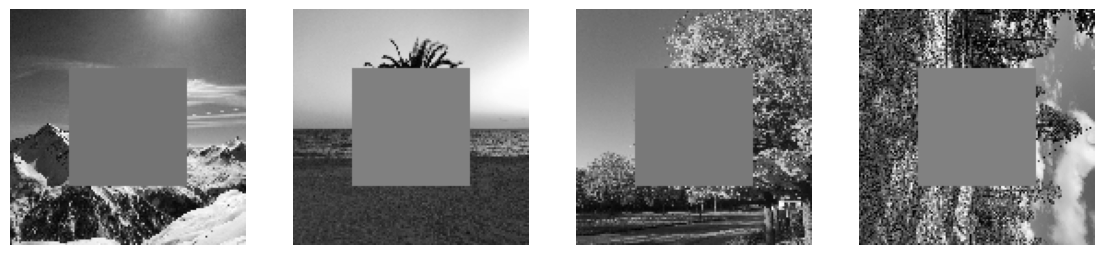

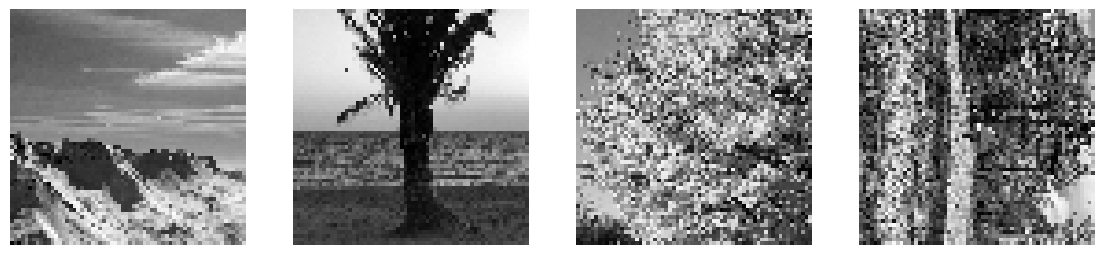

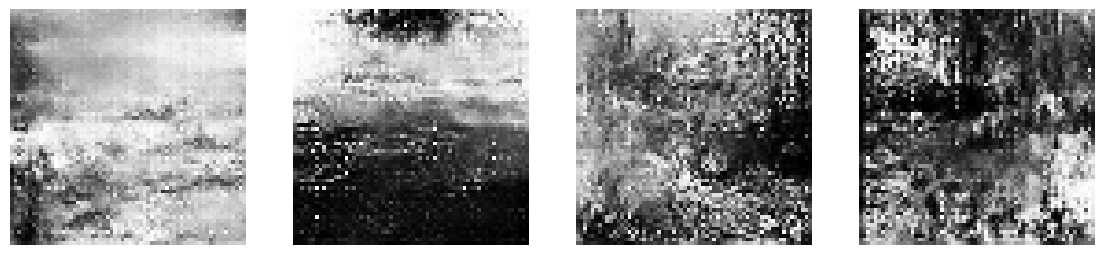

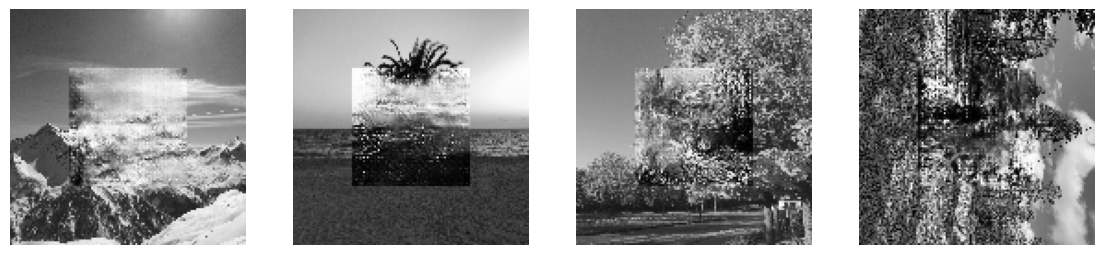

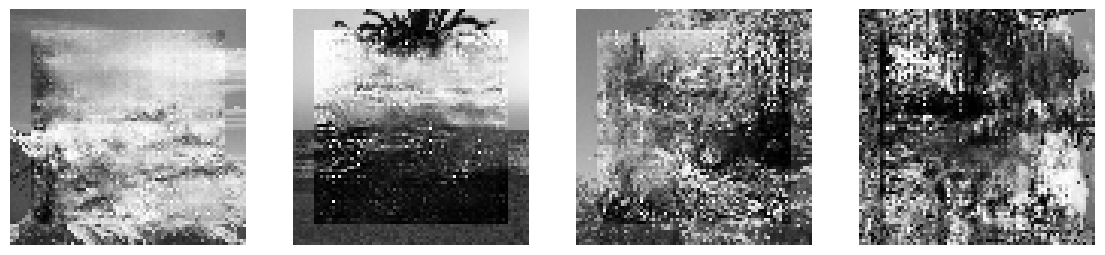

In [76]:
test_data = LandscapeDataset("own_data", image_transforms)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
img = test_loader.__iter__().__next__()
patch_pos, patches, images = get_patchs(img)
padded_patch_pos, padded_patches, _ = get_patchs(img, patch_size=64+14)

show_images(images)
show_images(patches)

model.to("cpu")
predicted_patches = model(images).cpu().detach()

show_images(predicted_patches)
show_images(fill_patch(patch_pos, images, predicted_patches))
show_images(fill_patch((7,7), padded_patches, predicted_patches))


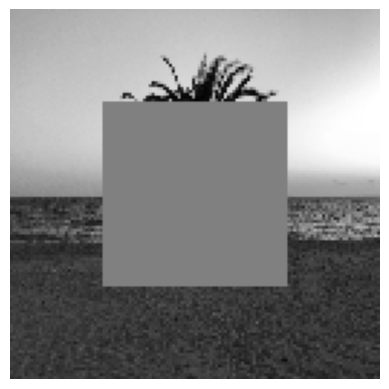

In [81]:
get

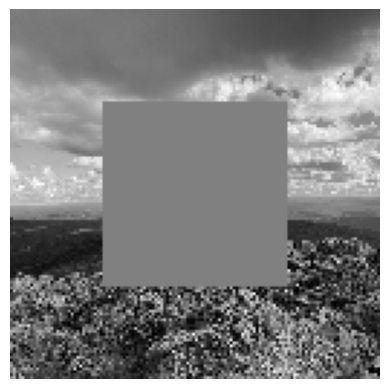

In [105]:
img = test_loader.__iter__().__next__()
patch_pos, patches, images = get_patchs(img)
show(images[0])

In [351]:
[file for file in os.listdir("own_data") if file.endswith((".jpg", 'JPG', 'jpeg',"png"))].index("IMG_9643.jpeg")

27

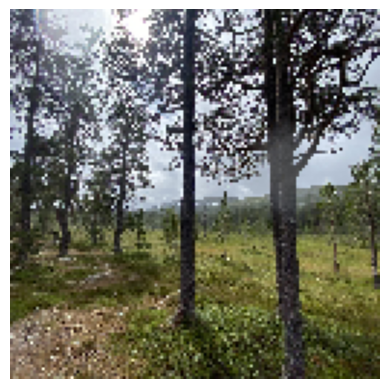

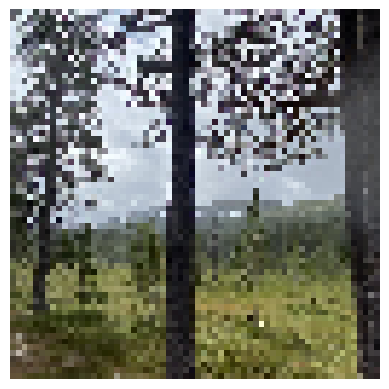

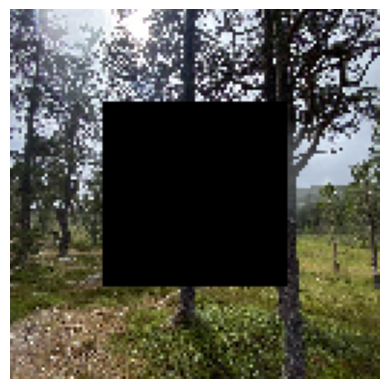

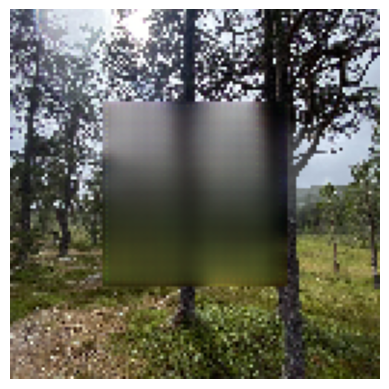

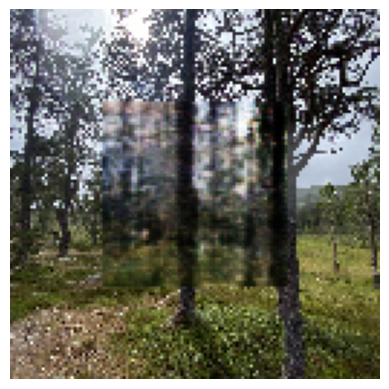

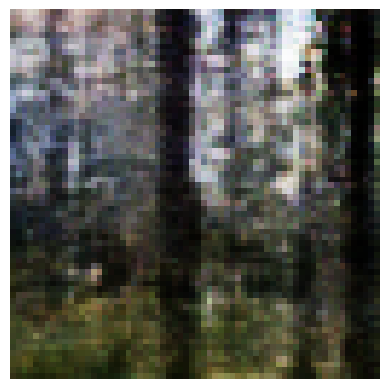

In [357]:
model_dir = "models/models/100_64_cae_gcp_colour"

device = torch.device("cpu")
model = AutoEncoderColour()
model.load_state_dict(torch.load(f"{model_dir}/model_gcp.pt"))
model.to(torch.device("cpu"))

test_data = LandscapeDataset("own_data", image_transforms_colours_f)
test_loader = DataLoader(test_data, batch_size=28)
img = test_loader.__iter__().__next__()
patch_pos, patches, images = get_patchs(img)

#GOOD 5, 6, 11, 12, 13, 14, 17, 25
#MEH 21, 26

idx = 27

#COLOUR
show((img[idx] + 1)/2)
plt.show()
show((patches[idx] + 1)/2)
plt.show()
show(get_patchs((images[idx] + 1)/2)[2])
plt.show()
show(fill_patch(patch_pos, (images[idx] + 1)/2, (model(images)[idx].detach() + 1)/2))
plt.show()
# ADV
model_dir = "models/models/100_64_gcp_colour"
model = AutoEncoderColour()
model.load_state_dict(torch.load(f"{model_dir}/model_gcp.pt"))
model.to(torch.device("cpu"))

show(fill_patch(patch_pos, (images[idx] + 1)/2, (model(images)[idx].detach() + 1)/2))
plt.show()

show((model(images)[idx].detach() + 1)/2)
plt.show()

# # GREYSCALE
# model_dir = "models/models/100_64_cae_gcp"

# model = AutoEncoder()
# model.load_state_dict(torch.load(f"{model_dir}/model_gcp.pt"))
# model.to(torch.device("cpu"))

# test_data = LandscapeDataset("own_data", image_transforms_f)
# test_loader = DataLoader(test_data, batch_size=28)
# img = test_loader.__iter__().__next__()
# patch_pos, patches, images = get_patchs(img)

# show((img[idx] + 1)/2)
# plt.show()
# show(get_patchs((images[idx] + 1)/2)[1])
# plt.show()
# show(get_patchs((images[idx] + 1)/2)[2])
# plt.show()
# show((model(images)[idx].detach() + 1)/2)
# plt.show()
# show(fill_patch(patch_pos, (images[idx] + 1)/2, (model(images)[idx].detach() + 1)/2))
# plt.show()
# # ADV
# model_dir = "models/models/800_64_gcp"
# model = AutoEncoder()
# model.load_state_dict(torch.load(f"{model_dir}/model_gcp.pt"))
# model.to(torch.device("cpu"))

# show(fill_patch(patch_pos, (images[idx] + 1)/2, (model(images)[idx].detach() + 1)/2))
# # plt.show()

In [346]:
# map range from -1 to 1 to 0 255
def map_range(x, in_min=-1, in_max=1, out_min=0, out_max=255):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

# pytorch peak signal to noise ratio (PSNR)
def psnr(img1, img2):
    mse = torch.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse))

In [358]:
test_data = LandscapeDataset("own_data", image_transforms_colours_f)
test_loader = DataLoader(test_data, batch_size=48)

# get mean MSE for all images in the testloader

total_mse = 0
total_l1 = 0
for img in test_loader:
    patch_pos, patches, images = get_patchs(img)
    predictions = model(images)
    total_mse += ((predictions - patches)**2).mean()
    total_l1 += ((predictions - patches).abs()).mean()

total_mse /= len(test_loader)
total_l1 /= len(test_loader)    


print(total_mse.item())
print(total_l1.item())


0.18171726167201996
0.2961236834526062
